<a href="https://colab.research.google.com/github/GRicci6/Bumblekite25/blob/main/pad_random_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
##Setting up the python environment
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import string
%matplotlib inline
import textwrap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import joblib

##Setting up BQ API
from google.cloud import bigquery

# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


##Set up Google sdk environment
##os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = ***
## Connect to the right GCP project
##os.environ['GCLOUD_PROJECT'] = '***'
##%load_ext google.cloud.bigquery
##client=bigquery.Client()

##project_id = "***"
##dataset_id = "***"
##work_project_id = '***'
##work_dataset_id = '***'

## Test set

In [5]:
#excludeIds = []
#for i in range(5):
#    excludeIds.append(pd.read_csv("321052_ids/321052_ids_fold" + str(i + 1) + ".csv"))
#excludeIds = pd.concat(excludeIds)
#excludeIds.to_csv('321052_ids/321052_ids.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '321052_ids/321052_ids_fold1.csv'

In [8]:
#importing test set
cases = pd.read_csv("cases_sequence_fold1_new.csv")
cases.head()

,person_id,visit_occurrence_id,date,year,distance_days,age,concept_name,concept_id,type,recency
0,866f0f39-ffbd-4b0b-bd43-da414e2e9353,67651425,2014-03-27,2014,9,53,Benign localized hyperplasia of prostate,40481080,condition,0
1,866f0f39-ffbd-4b0b-bd43-da414e2e9353,67651425,2014-03-27,2014,9,53,Raised prostate specific antigen,4245252,condition,0
2,866f0f39-ffbd-4b0b-bd43-da414e2e9353,67651425,2014-03-27,2014,9,53,Urinary tract obstruction,194406,condition,0
3,866f0f39-ffbd-4b0b-bd43-da414e2e9353,67651425,2014-03-27,2014,9,53,tamsulosin,21602669,drug,0
4,866f0f39-ffbd-4b0b-bd43-da414e2e9353,67651425,2014-03-27,2014,9,53,Body surface area,4201235,observation,0


In [9]:
cases.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })

,person_id,concept_id
0,000776e5-bcd4-4628-8566-7cc97bdf14cf,"[192680, 2414396, 192680, 2414397, 4272240, 24..."
1,00319e87-76c6-4287-a490-c9907df4d3e6,"[2000031975, 2000031980, 4145308, 4145308, 414..."
2,003c6a89-e1bf-4d82-b6a9-e1e26cdd7e97,[4037760]
3,0087eadd-9961-4284-bcfc-5e7dd0cc1d52,"[4296597, 315078, 4089462, 4201235, 4038735, 4..."
4,00c2259f-af98-463e-b4b5-044ed97202d3,"[321052, 40481089, 321052, 2211585, 764123, 32..."
...,...,...
688,fe4d89fb-b29e-4542-97b6-ad9e3cd5ebff,"[764123, 317576, 432867, 21601685, 4201235, 24..."
689,fe62ed18-164b-405c-a956-13a43e3da853,"[4299523, 4230911]"
690,feaa9e84-6b29-48af-8c24-8b806bfbe9d0,"[4038735, 4047454, 4041508, 4214956, 4041509, ..."
691,ff236816-5ab4-4393-8bd6-2c78e742efa6,"[320128, 437827, 4201235, 4038735, 4047454, 40..."


In [12]:
cases = pd.read_csv("cases_sequence_fold1_new.csv")
#cases = cases[~cases['person_id'].isin(excludeIds['person_id'])]
controls = pd.read_csv("controls_sequence_fold1_new.csv")
controls = controls.dropna()

Xcases = cases.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycases = np.ones(len(Xcases.index), dtype=np.int64)

Xcontrols = controls.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycontrols = np.zeros(len(Xcontrols.index), dtype=np.int64)

X = np.concatenate((Xcases, Xcontrols))
y = np.concatenate((ycases, ycontrols))

mm = -1
print(f'Number of features {mm}')
for lis in X:
    if len(lis) > mm:
        mm = len(lis)
mm
XX = np.zeros((len(X), mm), dtype=np.int64)
for i in range(len(X)):
    for j in range(len(X[i])):
        XX[i, j] = int(X[i][j])
print(f'Number of features {mm}')


from sklearn.utils import shuffle
X_test, y_test = shuffle(XX, y, random_state=0)

Number of features -1
Number of features 6452


## Validation set

In [15]:
#importing validation set
cases_val = pd.read_csv("cases_sequence_fold2_new.csv")
#cases_val = cases_val[~cases_val['person_id'].isin(excludeIds['person_id'])]
controls_val = pd.read_csv("controls_sequence_fold2_new.csv",engine='python')

Xcases_val = cases_val.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycases_val = np.ones(len(Xcases_val.index), dtype=np.int64)

Xcontrols_val = controls_val.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycontrols_val = np.zeros(len(Xcontrols_val.index), dtype=np.int64)

X_val = np.concatenate((Xcases_val, Xcontrols_val))
yy_val = np.concatenate((ycases_val, ycontrols_val))

mm = -1
for lis in X_val:
    if len(lis) > mm:
        mm = len(lis)

XX_val = np.zeros((len(X_val), mm), dtype=np.int64)
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        XX_val[i, j] = int(X_val[i][j])
XX[0]
print(f'Number of features {mm}')

from sklearn.utils import shuffle
X_val, y_val = shuffle(XX_val, yy_val, random_state=0)

Number of features 8929


## Training set

In [17]:
#importing  training set
cases_fold1 = pd.read_csv("cases_sequence_fold3_new.csv")
#cases_fold1 = cases_fold1[~cases_fold1['person_id'].isin(excludeIds['person_id'])]
controls_fold1 = pd.read_csv("controls_sequence_fold3_new.csv",engine='python')
controls_fold1 = controls_fold1.dropna()
cases_fold2 = pd.read_csv("cases_sequence_fold4_new.csv")
#cases_fold2 = cases_fold2[~cases_fold2['person_id'].isin(excludeIds['person_id'])]
controls_fold2 = pd.read_csv("controls_sequence_fold4_new.csv",engine='python')
controls_fold2 = controls_fold2.dropna()
cases_fold3 = pd.read_csv("cases_sequence_fold5_new.csv")
#cases_fold3 = cases_fold3[~cases_fold3['person_id'].isin(excludeIds['person_id'])]
controls_fold3 = pd.read_csv("controls_sequence_fold5_new.csv",engine='python')
controls_fold3 = controls_fold3.dropna()

Xcases_train_fold1 = cases_fold1.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycases_train_fold1 = np.ones(len(Xcases_train_fold1.index), dtype=np.int64)
Xcases_train_fold2 = cases_fold2.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycases_train_fold2 = np.ones(len(Xcases_train_fold2.index), dtype=np.int64)
Xcases_train_fold3 = cases_fold3.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycases_train_fold3 = np.ones(len(Xcases_train_fold3.index), dtype=np.int64)

Xcontrols_train_fold1 = controls_fold1.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycontrols_train_fold1 = np.zeros(len(Xcontrols_train_fold1.index), dtype=np.int64)
Xcontrols_train_fold2 = controls_fold2.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycontrols_train_fold2 = np.zeros(len(Xcontrols_train_fold2.index), dtype=np.int64)
Xcontrols_train_fold3 = controls_fold3.groupby(['person_id'], as_index=False).agg({'concept_id':lambda x: list(x) })['concept_id']
ycontrols_train_fold3 = np.zeros(len(Xcontrols_train_fold3.index), dtype=np.int64)

X_train = np.concatenate((Xcases_train_fold1, Xcontrols_train_fold1, Xcases_train_fold2, Xcontrols_train_fold2, Xcases_train_fold3, Xcontrols_train_fold3))
yy_train = np.concatenate((ycases_train_fold1, ycontrols_train_fold1, ycases_train_fold2, ycontrols_train_fold2, ycases_train_fold3, ycontrols_train_fold3))

mm = -1
for lis in X_train:
    if len(lis) > mm:
        mm = len(lis)

XX_train = np.zeros((len(X_train), mm), dtype=np.int64)
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        XX_train[i, j] = int(X_train[i][j])

print(f'Number of features {mm}')


from sklearn.utils import shuffle
X_train, y_train = shuffle(XX_train, yy_train, random_state=0)

feat_X_train = X_train.shape[1]
feat_X_val = X_val.shape[1]
feat_X_test = X_test.shape[1]
max_feat = max(feat_X_train, feat_X_val, feat_X_test)
X_train = np.pad(X_train, pad_width=((0, 0), (0, max_feat - feat_X_train)), mode='constant')
X_val = np.pad(X_val, pad_width=((0, 0), (0, max_feat - feat_X_val)), mode='constant')
X_test = np.pad(X_test, pad_width=((0, 0), (0, max_feat - feat_X_test)), mode='constant')

Number of features 8929


## Random Forest

In [18]:
#parameter search on validation set
best_val = -1
best_params = {}
nums_estimators = np.arange(70,221,20)
maxs_features = ["sqrt"]
max_depths = [None]
for num_estim in nums_estimators:
    for max_feat in maxs_features:
        for max_dep in max_depths:
            regressor = RandomForestRegressor(n_estimators=num_estim, max_features = max_feat, max_depth = max_dep, random_state=0)
            regressor.fit(X_train, y_train)
            val_pred = regressor.predict(X_val)
            auc = roc_auc_score(y_val, val_pred)
            if auc > best_val:
                best_val = auc
                best_params["n_estimators"] = num_estim
                best_params["max_features"] = max_feat
                best_params["max_depth"] = max_dep
best_params, best_val

({'n_estimators': np.int64(210), 'max_features': 'sqrt', 'max_depth': None},
 np.float64(0.9027443171262316))

In [19]:
best_params["max_depth"]

In [20]:
best_num_estim = best_params["n_estimators"]
best_max_feat = best_params["max_features"]
best_max_dep = best_params["max_depth"]
regressor = RandomForestRegressor(n_estimators = best_num_estim, max_features = best_max_feat, max_depth = best_max_dep, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
roc_auc_score(y_test, y_pred)

np.float64(0.9069926919854769)

In [31]:
joblib.dump(regressor,'models/random_forest_1.joblib')

['models/random_forest_1.joblib']

In [32]:
#random forest model saving
fold_save = "1"
save_name = "models/random_forest_" + fold_save + ".joblib"
loaded_model = joblib.load(save_name)
result = loaded_model.predict(X_test)
roc_auc_score(y_test, result)

np.float64(0.9069926919854769)

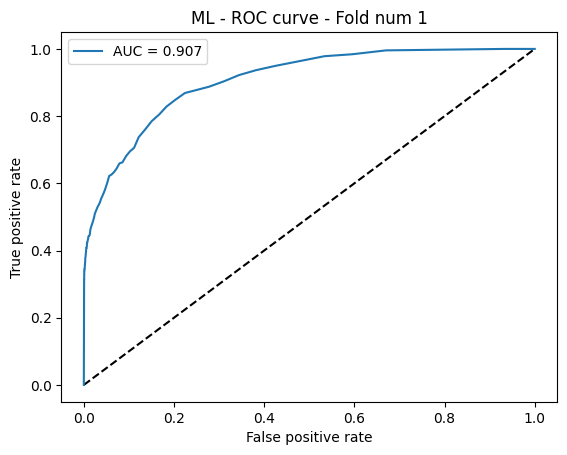

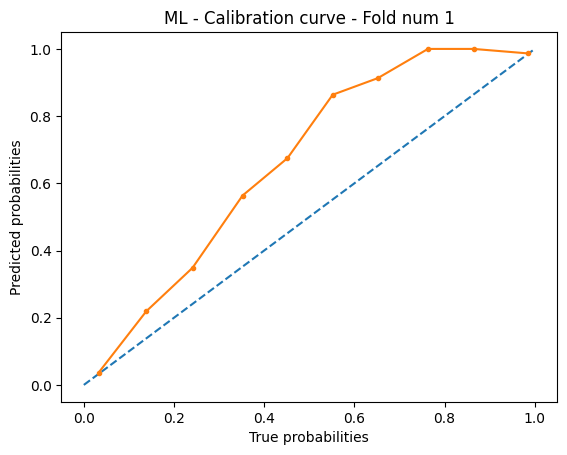

optimal_threshold =  0.0761904761904762
AUC =  0.9069926919854769
Specificity =  0.8051948051948052
Sensitivity =  0.8326118326118326


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

y_pred = result

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

fold_num_print = 'Fold_num_1'
fold_title = 'Fold num 1'

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ML - ROC curve - ' + str(fold_title))
plt.legend(loc='best')
plt.savefig('cv/PAD_ML_auc_curve_'+str(fold_num_print)+'.jpeg')
plt.show()

# reliability diagram
fop, mpv = calibration_curve(y_test, y_pred, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.xlabel('True probabilities')
plt.ylabel('Predicted probabilities')
plt.title('ML - Calibration curve - '+ str(fold_title))
plt.savefig('cv/PAD_ML_calibration_'+fold_num_print+'.jpeg')
plt.show()

gmeans = np.sqrt(tpr_keras * (1-fpr_keras))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds_keras[ix]
print("optimal_threshold = ", optimal_threshold)

cm=confusion_matrix(y_test, y_pred>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
# Specificity or true negative rate
TNR = TN/(TN+FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

cm,TP,TN,FP,FN,auc_keras,TNR,TPR

print("AUC = ", auc_keras)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
y_true = y_test

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
# print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

In [36]:
auc_std

NameError: name 'auc_std' is not defined

In [37]:
cm=confusion_matrix(y_test, y_pred>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
cm

array([[5193, 1044],
       [ 135,  558]])

In [39]:
fold_num = 1
pd.DataFrame(fpr_keras).to_csv("plots/fpr" + str(fold_num) + ".csv")
pd.DataFrame(tpr_keras).to_csv("plots/tpr" + str(fold_num) + ".csv")
pd.DataFrame(fop).to_csv("plots/fop" + str(fold_num) + ".csv")
pd.DataFrame(mpv).to_csv("plots/mpv" + str(fold_num) + ".csv")
pd.DataFrame([auc_keras]).to_csv("plots/auc" + str(fold_num) + ".csv")

In [40]:
d = {'auc': auc_keras, 'specificity': TNR, 'sensitivity': TPR}
df = pd.DataFrame(data=d, index = [0], dtype=np.float64)
df.to_csv('cv/auc_specificity_sensitivity_fold1.csv', index=False)

In [41]:
print("AUC = ", auc_keras)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

AUC =  0.9069926919854769
Specificity =  0.8051948051948052
Sensitivity =  0.8326118326118326
